In [ ]:
import $plugin.$ivy.`org.spire-math::kind-projector:0.9.8`
import $ivy.`org.typelevel::cats-core:1.4.0`, cats._, cats.implicits._, cats.data.{EitherK, NonEmptyVector}
import $ivy.`org.typelevel::cats-free:1.4.0`
import $ivy.`org.typelevel::cats-effect:1.0.0`, cats.effect.{IO}

# eDSLs in Scala using the Tagless Final Encoding

Keith Schulze, Tranquility Crew

# Domain Specific Languages (DSL)

- Small computer languages focused on a specific application domain or system. 
- Typically can't write entire applications in a DSL.
- Examples:
    - SQL
    - GLSL
    - HTML
    - CSS


# Embedded Domain Specific Languages (eDSL)

- Small programs embedded in a host language that compile to statements/expressions in the host language.
- Separate definition and interpretation/execution of a program


## Why build an eDSL?

- Separate of concerns
- Potential to optimise computations
- Can make testing easier
- Purely functional API over imperative code 

# eDSLs in Scala

Example: Hutton's Razor - Adding integers

In [ ]:
// define an algebra for our mini language
sealed trait AddIntAlg
case class LitInt(value: Int) extends AddIntAlg
case class Add(a: AddIntAlg, b: AddIntAlg) extends AddIntAlg

In [ ]:
// smart constructors
def int(i: Int): AddIntAlg = LitInt(i)
def add(a: AddIntAlg, b: AddIntAlg): AddIntAlg = Add(a, b)

In [ ]:
// build a program using our algebra
val program = add(int(1), int(10))

In [ ]:
// interpreter for our algebra
def interpret(alg: AddIntAlg): Int = alg match {
    case LitInt(i) => i
    case Add(a, b) => interpret(a) + interpret(b)
}

In [6]:
interpret(program)

res5: Int = 11

# Combining Algebras for a DSL
What happens if we want a DSL to add integers and concatenate strings?

In [ ]:
sealed trait IntStringAlg
case class LitInt(value: Int) extends IntStringAlg
case class Add(a: IntStringAlg, b: IntStringAlg) extends IntStringAlg // Oops!
case class LitString(value: String) extends IntStringAlg
case class StringConcat(a: IntStringAlg, b: IntStringAlg) extends IntStringAlg // Oh oh!

Yikes! We're starting to encounter some limitations:
- Forced to modify our existing DSL or create a new DSL with both operations.
- Lack requisite type information to interpret our DSL correctly

# GADTs to the rescue?

In [ ]:
sealed trait IntStringAlg[A]

case class LitInt(value: Int) extends IntStringAlg[Int]
case class Add(a: IntStringAlg[Int], b: IntStringAlg[Int]) extends IntStringAlg[Int]
case class LitString(value: String) extends IntStringAlg[String]
case class StringConcat(a: IntStringAlg[String], b: IntStringAlg[String])
    extends IntStringAlg[String]

def int(i: Int): IntStringAlg[Int] = 
    LitInt(i)
def add(a: IntStringAlg[Int], b: IntStringAlg[Int]): IntStringAlg[Int] = 
    Add(a, b)
def str(s: String): IntStringAlg[String] = 
    LitString(s)
def concat(a: IntStringAlg[String], b: IntStringAlg[String]): IntStringAlg[String] = 
    StringConcat(a, b)

def interpret[A](alg: IntStringAlg[A]): A = alg match {
    case LitInt(v) => v
    case LitString(s) => s
    case Add(a, b) => interpret(a) + interpret(b)
    case StringConcat(a, b) => interpret(a) + interpret(b)
}

In [8]:
interpret(add(int(1), int(4)))
interpret(concat(str("hello "), str("world!")))

res7_0: Int = 5
res7_1: String = "hello world!"

# GADTs to the rescue?

- Required to have a single algebra that describes all the operations in our DSL.
- GADTs have [bugs](https://gist.github.com/pchiusano/1369239) in Scala.

> Friends don't let friends use GADTs in Scala
>
>
> -- <cite>John Degoes</cite>

# Free Monad/Applicative DSLs

[Typelevel `cats` implementation of Free Monad](https://typelevel.org/cats/datatypes/freemonad.html)

Implement AddInteger and ConcatString DSLs with Free Monads and then combine them.

In [ ]:
import cats.{Id, InjectK, ~>}
import cats.free.Free

In [ ]:
// define algebra
sealed trait AddIntAlg[A]
case class LitInt(value: Int) extends AddIntAlg[Int]
case class Add(a: Int, b: Int) extends AddIntAlg[Int]

In [ ]:
// smart constructor that lift/inject into free
class AddInteger[F[_]](implicit I: InjectK[AddIntAlg, F]) {
    def int(v: Int): Free[F, Int] = 
        Free.inject[AddIntAlg, F](LitInt(v))
    def add(a: Int, b: Int): Free[F, Int] = 
        Free.inject[AddIntAlg, F](Add(a, b))
}

object AddInteger {
    implicit def addInteger[F[_]](
        implicit I: InjectK[AddIntAlg, F]
    ): AddInteger[F] = new AddInteger[F]
}

In [ ]:
// define algebra
sealed trait ConcatStringAlg[A]
case class LitString(value: String) extends ConcatStringAlg[String]
case class Concat(a: String, b: String) extends ConcatStringAlg[String]

// smart constructor that lift/inject into free
class ConcatString[F[_]](implicit I: InjectK[ConcatStringAlg, F]) {
    def str(v: String): Free[F, String] = 
        Free.inject[ConcatStringAlg, F](LitString(v))
    def concat(a: String, b: String): Free[F, String] = 
        Free.inject[ConcatStringAlg, F](Concat(a, b))
}

object ConcatString {
    implicit def concatString[F[_]](
        implicit I: InjectK[ConcatStringAlg, F]
    ): ConcatString[F] = new ConcatString[F]
}

In [ ]:
// define combined algebra
type IntStringAlg[A] = EitherK[AddIntAlg, ConcatStringAlg, A]

//define our program using Free monad DSL
def program(
    implicit 
    I: AddInteger[IntStringAlg], 
    S: ConcatString[IntStringAlg]
): Free[IntStringAlg, Tuple2[Int, String]] = for {
    a <- I.int(1)
    b <- I.int(4)
    c <- I.int(1000)
    d <- I.add(a, b)
    e <- I.add(c, d)
    x <- S.str("hello ")
    y <- S.str("world!")
    z <- S.concat(x, y)
} yield (e, z)

In [ ]:
// define interpreters
object AddIntInterpreter extends (AddIntAlg ~> Id) {
  def apply[A](i: AddIntAlg[A]) = i match {
    case LitInt(i) => i
    case Add(a, b) => a + b
  }
}

object ConcatStringInterpreter extends (ConcatStringAlg ~> Id) {
  def apply[A](fa: ConcatStringAlg[A]) = fa match {
    case LitString(s) => s
    case Concat(a, b) => a + b
  }
}

// define combined interpreter
val interpreter: IntStringAlg ~> Id =  AddIntInterpreter or ConcatStringInterpreter

We now have the 3 element to run our program: Algebras, Program and Interpreters

In [15]:
import AddInteger._, ConcatString._

//run program
program.foldMap(interpreter)

import AddInteger._, ConcatString._

//run program

res14_1: (Int, String) = (1005, "hello world!")

## Tagless Final

> Carette, Jacques, Oleg Kiselyov, and Chung-chieh Shan. 2009. Finally tagless, partially evaluated: Tagless staged interpreters for simpler typed languages. Journal of Functional Programming 19(5):509–543.

Oleg has produced really nice teaching material that covers [Tagless Final style](http://okmij.org/ftp/tagless-final/) in OCaml and Haskell.

Familiar DSL structure:
- Algebra
- Program
- Interpreter

<blockquote class="twitter-tweet" data-lang="en"><p lang="en" dir="ltr">Final-tagless lets you build type-safe DSLs with type classes. Instances of the type class are interpreters for the DSL.<br><br>Free Monad lets you build type-safe DSLs with a data structure. Functions on the data structure (called natural transformations) are interpreters for the DSL. <a href="https://t.co/Pwu8Ixq2di">https://t.co/Pwu8Ixq2di</a></p>&mdash; John Ⓐ De Goes (@jdegoes) <a href="https://twitter.com/jdegoes/status/1059056721643991040?ref_src=twsrc%5Etfw">November 4, 2018</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

In [ ]:
// Define Algebra
trait AddIntAlg[F[_]] {
    def int(i: Int): F[Int]
    def add(a: Int, b: Int): F[Int]
}

In [ ]:
// Define Program
def program[F[_]: Monad](I: AddIntAlg[F]): F[Int] = for {
    a <- I.int(1)
    b <- I.int(4)
    c <- I.int(1000)
    d <- I.add(a, b)
    e <- I.add(c, d)
} yield e

In [ ]:
// Define Interpreter
object AddIntInterpreterId extends AddIntAlg[Id] {
    def int(i: Int): Id[Int] = i
    def add(a: Int, b: Int): Id[Int] = a + b
}

In [19]:
program(AddIntInterpreterId)

res18: Id[Int] = 1005

# Combining Tagless Final Algebras

Let's combine AddInteger and ConcatString

In [ ]:
trait ConcatStringAlg[F[_]] {
    def str(s: String): F[String]
    def concat(a: String, b: String): F[String]
}

object ConcatStringInterpreterId extends ConcatStringAlg[Id] {
    def str(s: String): Id[String] = s
    def concat(a: String, b: String): Id[String] = a + b
}

In [ ]:
def program[F[_]: Monad](
    I: AddIntAlg[F], 
    S: ConcatStringAlg[F]
): F[Tuple2[Int, String]] = for {
    a <- I.int(1)
    b <- I.int(4)
    c <- I.int(1000)
    d <- I.add(a, b)
    e <- I.add(c, d)
    x <- S.str("hello ")
    y <- S.str("world!")
    z <- S.concat(x, y)
} yield (e, z)

In [22]:
program(AddIntInterpreterId, ConcatStringInterpreterId)

res21: (Int, String) = (1005, "hello world!")

| Tagless Final DSL | Free Monad/Applicative DSL |
| :---------------------------------------- | :--------------------------------------------------------------- |
| Compiles to expressions in host language  | Compiles to data structure that represents the computation |
| Abstracts over the effect type            | Stack-safe by default |
| Vertically and horizontally composable    | Inspection of inner program structure allows for optimisation |
| Concise encoding                          | |
| Efficient                                 | |
| Inspection and optimisation of call stack more challenging | |
| Stack-safety is dependent on the Effect type | |

# Tagless Final DSL Example: Banking Service

In [ ]:
import scala.collection.mutable.Map
import scala.concurrent.{Future, ExecutionContext}
import scala.util.{Success, Failure}

sealed trait BankingError extends Exception
case class AccountError(message: String) extends BankingError
case class WithdrawError(message: String) extends BankingError
case class DepositError(message: String) extends BankingError
case class TransferError(message: String) extends BankingError

case class Amount(value: BigDecimal)
object Amount {
    def apply(amount: Double): Amount = Amount(BigDecimal(amount))
}

type AccountId = Int
case class Account(id: AccountId, balance: Amount)


case class From[A](value: A)
case class To[A](value: A)
type TransferResult = Either[BankingError, (From[Amount], To[Amount])]

A typical BankingService you might encounter in Scala

In [ ]:
trait BankingService {
    def account(accId: AccountId): Future[Option[Account]]
    def balance(acc: Account): Future[Amount]
    def deposit(acc: Account, amount: Amount): Future[Either[BankingError, Amount]]
    def withdraw(acc: Account, amount: Amount): Future[Either[BankingError, Amount]]
    def transfer(from: From[Account], to: To[Account], amount: Amount): Future[TransferResult]
}

In [ ]:
class ATMService(bs: BankingService) {
    def transferMoolla(fromAccId: AccountId, toAccId: AccountId, amount: Amount)(
        implicit ec: ExecutionContext
    ): Future[TransferResult] = {
        bs.account(fromAccId).flatMap(from => {
            bs.account(toAccId).flatMap(to => (from, to) match {
                case (Some(acc1), Some(acc2)) => bs.transfer(From(acc1), To(acc2), amount)
            })
        })
    }
    
}

What might this look like if we create a Tagless Final DSL for the Banking service

In [ ]:
trait Banking[F[_]] {
    def account(accId: AccountId): F[Account]
    def balance(acc: Account): F[Amount]
    def deposit(acc: Account, amount: Amount): F[Amount]
    def withdraw(acc: Account, amount: Amount): F[Amount]
    def transfer(from: From[Account], to: To[Account], amount: Amount): F[TransferResult]
}

In [ ]:
class ATMService[F[_]: Monad](bs: Banking[F]) {
    def transferMoolla(fromAccId: AccountId, toAccId: AccountId, amount: Amount): F[TransferResult] =
        for {
            fromAcc <- bs.account(fromAccId)
            toAcc   <- bs.account(toAccId)
            result  <- bs.transfer(From(fromAcc), To(toAcc), amount)
        } yield result
}

In [ ]:
import scala.concurrent.ExecutionContext.Implicits.global

object BankingInterp extends Banking[Future] {
    val accs: Map[AccountId, Account] =
        Map(
            0 -> Account(1, Amount(0.0)),
            1 -> Account(2, Amount(100000.0)),
            2 -> Account(3, Amount(1.0))
        )

    def account(accId: AccountId): Future[Account] =
        accs.get(accId) match {
            case Some(acc) => Future.successful(acc)
            case None => Future.failed(AccountError("Account does not exist"))
        }

    def balance(acc: Account): Future[Amount] = Future.successful(acc.balance)
    def deposit(acc: Account, amount: Amount): Future[Amount] =
        if (amount.value >= 0) {
            val newBalance = Amount(acc.balance.value + amount.value)
            accs.update(acc.id, acc.copy(balance=newBalance))
            Future.successful(newBalance)
        } else {
            Future.failed(DepositError("Cannot deposit negative amount."))
        }

    def withdraw(acc: Account, amount: Amount): Future[Amount] =
        if (amount.value >= 0) {
            val newBalance = Amount(acc.balance.value - amount.value)
            accs.update(acc.id, acc.copy(balance=newBalance))
            Future.successful(newBalance)
        } else {
            Future.failed(WithdrawError("Cannot withdraw a negative amount."))
        }

    def transfer(from: From[Account], to: To[Account], amount: Amount): Future[TransferResult] = for {
        out1 <- withdraw(from.value, amount)
        out2 <- deposit(to.value, amount)
    } yield Right((From(out1), To(out2)))
}

In [29]:
val atm = new ATMService(BankingInterp)

val tranferResult = atm.transferMoolla(0, 1, Amount(50000))

: 

Note this doesn't seem to work in Jupyter scala (Almond). Try running it using the Ammonite script (`banking.sc`).

# Tagless Final DSL Example: Cell counting

In [ ]:
interp.repositories() ++= Seq(coursier.maven.MavenRepository("http://maven.imagej.net/content/groups/public/"))

In [ ]:
import $ivy.`net.imglib2:imglib2:5.5.0`
import $ivy.`io.scif:scifio:0.37.2`

In [ ]:
import $file.ImgUtils, ImgUtils._, previews._

In [ ]:
val sourcePath = "http://imagej.net/images"
//sourcePath = System.getProperty("user.home") + "/data"
val cells = ij.scifio().datasetIO().open(sourcePath + "/FluorescentCells.jpg")


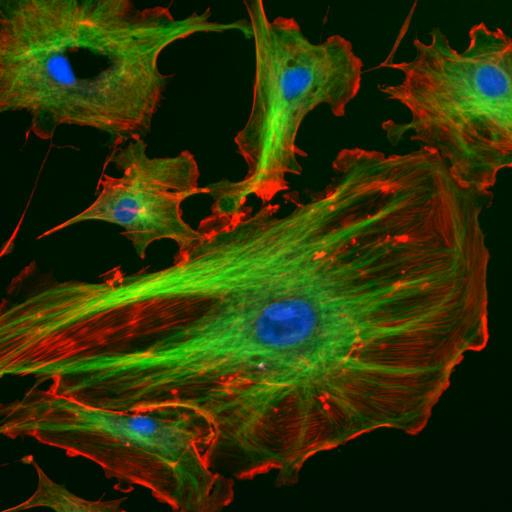

In [34]:
cells.preview

In [ ]:
import scala.collection.JavaConverters._
import scala.util.control.NonFatal

import io.scif.img.ImgOpener

import net.imglib2.algorithm.labeling.{ConnectedComponents}
import net.imglib2.img.{Img, ImgView}
import net.imglib2.img.array.ArrayImgFactory
import net.imglib2.roi.labeling.{ImgLabeling, LabelRegions}
import net.imglib2.`type`.NativeType
import net.imglib2.`type`.numeric.{RealType, IntegerType}
import net.imglib2.`type`.numeric.integer.{IntType, UnsignedByteType}
import net.imglib2.`type`.logic.BitType
import net.imglib2.view.Views

In [ ]:
// Algebra
trait ImgProcessor[F[_], A] {
    def readImg(path: String): F[Img[A]]
    def extractChannel(img: Img[A], channel: Int): F[Img[A]]
    def smooth(img: Img[A], sigma: Double): F[Img[A]]
    def threshold(img: Img[A], value: A): F[Img[BitType]]
    def label(mask: Img[BitType]): F[ImgLabeling[Int, BitType]]
    def filter(label: ImgLabeling[Int, BitType], minSize: Double): F[ImgLabeling[Int, BitType]]
    def extractSizes(label: ImgLabeling[Int, BitType]): F[List[Double]]
}

In [ ]:
// Program
def program[F[_]: Monad](
    ip: ImgProcessor[F, UnsignedByteType]
): F[Tuple2[Int, List[Double]]] = for {
    img    <- ip.readImg("http://imagej.net/images/FluorescentCells.jpg")
    n      <- ip.extractChannel(img, 2)
    s      <- ip.smooth(n, 2.0)
    m      <- ip.threshold(s, new UnsignedByteType(60))
    l      <- ip.label(m)
    filtL  <- ip.filter(l, 100.0)
    result <- ip.extractSizes(filtL)
} yield (result.size, result)

In [ ]:
trait ImgProcessorInterp extends ImgProcessor[IO, UnsignedByteType] {
    def readImg(path: String): IO[Img[UnsignedByteType]] = {
        val io = new ImgOpener()
        try {
            IO(io.openImg(path.toString, new UnsignedByteType))
        } catch {
            case NonFatal(e) => IO.raiseError(e)
        }
            
    }
    
    def extractChannel(img: Img[UnsignedByteType], channel: Int): IO[Img[UnsignedByteType]] = 
        IO {
            ImgView.wrap(Views.hyperSlice(img, 2, channel), img.factory())
        }
    
    def smooth(img: Img[UnsignedByteType], sigma: Double): IO[Img[UnsignedByteType]] = 
        IO {
            ImgView.wrap(ij.op().filter().gauss(img, sigma), img.factory())
        }
    
    def threshold(img: Img[UnsignedByteType], value: UnsignedByteType): IO[Img[BitType]] = 
        IO {
        val ii = ij.op().threshold().apply(img, value)
        val out = ij.op().create().img(ii)
        ij.op().copy().iterableInterval(out, ii)
        out
    }
    
    def label(mask: Img[BitType]): IO[ImgLabeling[Int, BitType]] = IO {
        ij.op().labeling().cca(mask, ConnectedComponents.StructuringElement.EIGHT_CONNECTED)
    }
    
    def filter(label: ImgLabeling[Int, BitType], minSize: Double): IO[ImgLabeling[Int, BitType]] = IO {
        val regions = new LabelRegions(label).iterator().asScala.toList
        val filteredImg = new ArrayImgFactory[BitType]().create(label, new BitType)
        regions.filter( r => ij.op().geom().size(r).get() >= minSize)
            .foreach(r => {
                val rCursor = r.localizingCursor
                val rRA = r.randomAccess
                val fiRA = filteredImg.randomAccess
                
                while(rCursor.hasNext()) {
                    rCursor.fwd()
                    rRA.setPosition(rCursor)
                    fiRA.setPosition(rCursor)
                    fiRA.get().set(rRA.get().get())
                }
            })
        ij.op().labeling().cca(filteredImg, ConnectedComponents.StructuringElement.EIGHT_CONNECTED)
    }
    
    def extractSizes(label: ImgLabeling[Int, BitType]): IO[List[Double]] = IO {
        val regions = new LabelRegions(label).iterator().asScala.toList
        regions.map( r => ij.op().geom().size(r).get())
    }
}

object IPInterp extends ImgProcessorInterp

In [39]:
program(IPInterp).unsafeRunSync

[INFO] Populating metadata
[INFO] Populating metadata


res38: (Int, List[Double]) = (
  6,
  List(719.0, 987.0, 823.0, 543.0, 2348.0, 533.0)
)

We can see it's outputting something, but we can't verify it correct. It would be nice to see the intermediate images. Let's create a Debugging interpreter that displays a preview for DSL methods that output an image i.e., `readImg`, `extractChannel`, `smooth`, `threshold`, `label`, `filter`.

In [40]:
object DebugIPInterp extends ImgProcessorInterp {
    override def readImg(path: String): IO[Img[UnsignedByteType]] =
        super.readImg(path).map(i => {
            Preview[Img[UnsignedByteType]].preview(i)
            i
        })
    override def extractChannel(img: Img[UnsignedByteType], channel: Int): IO[Img[UnsignedByteType]] =
        super.extractChannel(img, channel).map(i => {
            Preview[Img[UnsignedByteType]].preview(i)
            i
        })
    override def smooth(img: Img[UnsignedByteType], sigma: Double): IO[Img[UnsignedByteType]] =
        super.smooth(img, sigma).map(i => {
            Preview[Img[UnsignedByteType]].preview(i)
            i
        })
    override def threshold(img: Img[UnsignedByteType], value: UnsignedByteType): IO[Img[BitType]] =
        super.threshold(img, value).map(m => {
            Preview[Img[BitType]].preview(m)
            m
        })
    override def label(mask: Img[BitType]): IO[ImgLabeling[Int, BitType]] =
        super.label(mask).map(l => {
            val img = l.getIndexImg
            Preview[Img[BitType]].preview(ImgView.wrap(img, new ArrayImgFactory(new BitType)))
            l
        })
    override def filter(label: ImgLabeling[Int, BitType], minSize: Double): IO[ImgLabeling[Int, BitType]] =
        super.filter(label, minSize).map(l => {
            val img = l.getIndexImg
            Preview[Img[BitType]].preview(ImgView.wrap(img, new ArrayImgFactory(new BitType)))
            l
        })
}

defined object DebugIPInterp

[INFO] Populating metadata
[INFO] Populating metadata



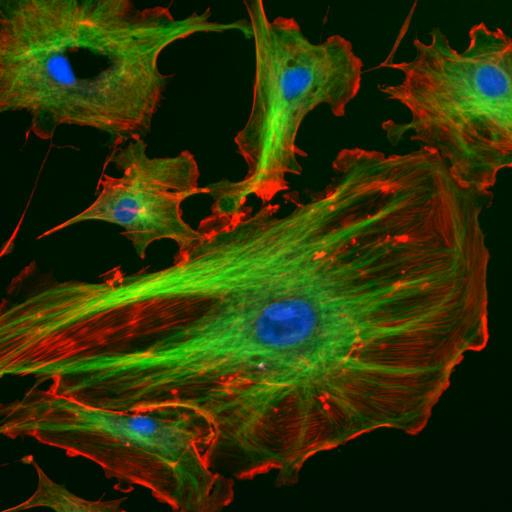


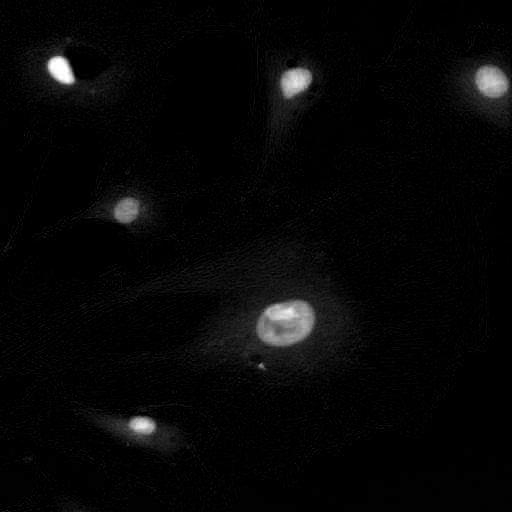


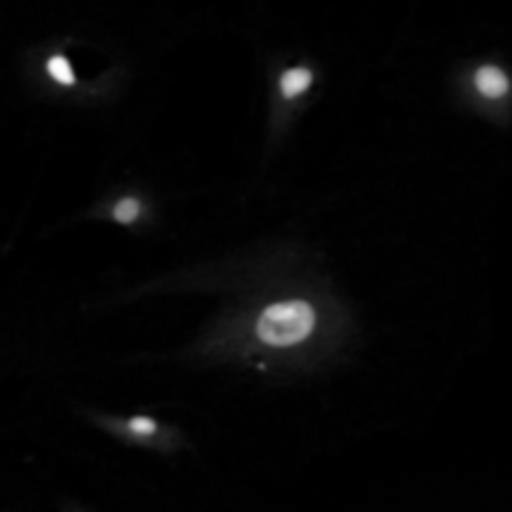


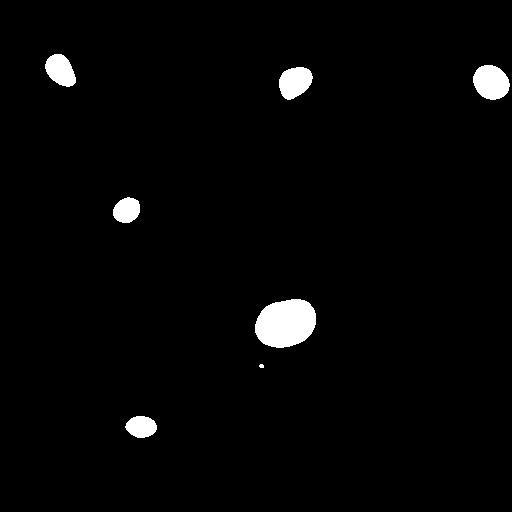


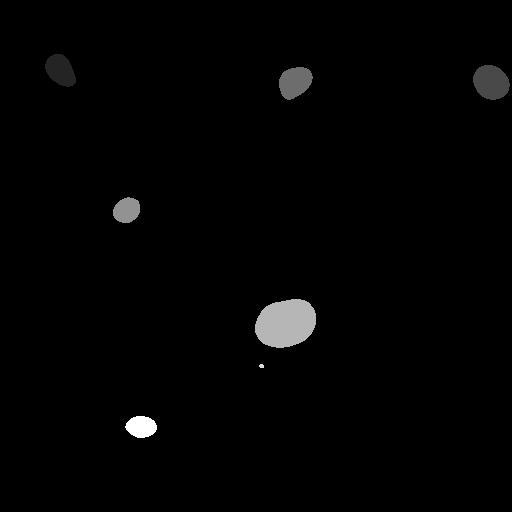


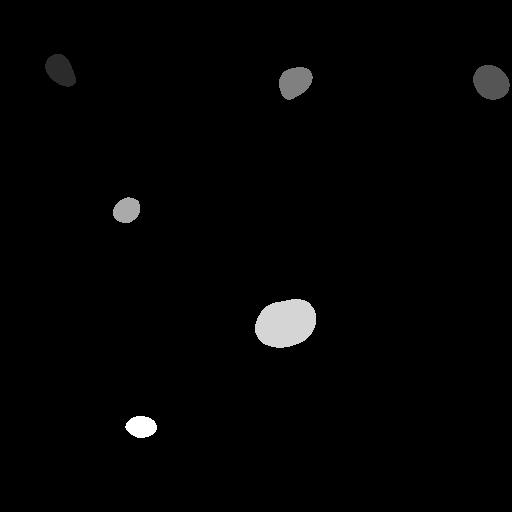

res40: (Int, List[Double]) = (
  6,
  List(719.0, 987.0, 823.0, 543.0, 2348.0, 533.0)
)

In [41]:
program(DebugIPInterp).unsafeRunSync

# Thank you

So much more fun to be had!
- Nesting Tagless Final Algebras
- [Optimising](http://okmij.org/ftp/tagless-final/course/optimizations.html) [Tagless](https://typelevel.org/blog/2018/06/27/optimizing-tagless-final-2.html) [Final](https://typelevel.org/blog/2017/12/27/optimizing-final-tagless.html)
- [Error handling with Tagless Final](https://typelevel.org/blog/2018/08/25/http4s-error-handling-mtl.html)
- [Effect](http://degoes.net/articles/effects-without-transformers) [types](http://degoes.net/articles/polymorphic-bifunctors)
- Interesting talks:
    - [Building a Tagless Final DSL for WebGL](https://www.slideshare.net/LukaJacobowitz/building-a-tagless-final-dsl-for-webgl)
    - [Advanced Tagless Final - Saying Farewell to Free](https://www.slideshare.net/LukaJacobowitz/advanced-tagless-final-saying-farewell-to-free)